# Deep Learning: Assignment 1 - Tiddo Loos - 2574974

# part2

In [1]:
import matplotlib.pyplot as plt
import math
import random

In [2]:
# -- assignment 1 --
import numpy as np
from urllib import request
import gzip
import pickle
import os

def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(np.int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).
     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [3]:
class NeuralNet:
    def __init__(self, w, v, b1, b2, lr):
        self.w = w
        self.v = v
        self.b1 = b1
        self.b2 = b2
        self.learn = lr
        
    def softmax(self, x):
        exps = [math.exp(value) for value in x]
        return [(value / sum(exps)) for value in exps]

    
    def sigmoid(self, x):
        y = 1/(1+math.exp(-x))
        return y

    
    def forward(self, x):
        k = [0., 0., 0.]
        h = [0.,0.,0.]
        s = [0., 0.]
        for i in range(len(k)):
            k[i] += self.w[0][i] * x[0] + self.w[1][i] * x[1] + self.b1[i]
        for i in range(len(k)):
            h[i] += (self.sigmoid(k[i]))
        for i in range(len(s)):
            s[i] += h[0]*self.v[0][i] + h[1]*self.v[1][i] + h[2]*self.v[2][i] + self.b2[i]
        pred = self.softmax(s)
        return pred, k, s, h 


    def backprop(self, labels, pred, k, s, h, x):
        dy = [0., 0.]
        dk = [0., 0., 0.]
        dh= [0.,0.,0.]
        dw = [[0.,0.,0.], [0., 0., 0.]]
        dv = [[0.,0.], [0.,0.], [0.,0.]]
        db2 = [0, 0]
        db1 = [0, 0, 0]
        for i in range(len(s)):
            dy[i] = pred[i] - labels[i]
            for j in range(len(k)):
                dv[j][i] = dy[i] * h[j]
                dh[j] *= dy[i] * self.v[j][i]  
            db2[i] = dy[i]
        for i in range(len(h)):
            dk[i] = dh[i] * h[i] * (1-h[i])
        for i in range(len(x)):
            for j in range(len(w)):
                dw[i][j] = dk[j]*x[i]
            db1[j]= dk[j]
        return dw, db1, dv, db2, dk, dh
    
    
    def update_weights(self, weight, update, bias = False):
        if bias:
            for i in range(len(weight)):
                weight[i] = weight[i] - (self.learn * update[i])
        else:
            for i in range(len(weight)):
                for j in range(len(weight[i])):
                    weight[i][j] = weight[i][j] - (self.learn * update[i][j])
                    
                    
    def loss(self, pred, label):
        true_index = label.index(1)
        return -math.log(pred[true_index])

# Question 3

In [4]:
#initialize
w = [[1.,1.,1.], [-1., -1., -1.]]
v = [[1.,1.], [-1.,-1.], [-1.,-1.]]
b1 = [0.,0.,0.]
b2 = [0.,0.]
lr = 1.0

#data
x = [1, -1]
labels = [1, 0]

#initialize network
nn= NeuralNet(w, v, b1, b2, lr)

#one cycle
pred, k, s, h = nn.forward(x)
dw, db1, dv, db2, dk, dh = nn.backprop(labels, pred, k, s, h, x)
print('dw=',dw)
print('b1=',db1)
print('dv=',dv)
print('b2=',db2)

dw= [[-0.0, -0.0, 0.0], [0.0, 0.0, 0.0]]
b1= [0, -0.0, 0]
dv= [[-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116]]
b2= [-0.5, 0.5]


# Question 4

In [5]:
def cycle(nn, x, labels, val = False):
    pred, k, s, h = nn.forward(x)
    if val == False:
        dw, db1, dv, db2, dk, dh = nn.backprop(labels, pred, k, s, h, x)
        nn.update_weights(nn.w, dw)
        nn.update_weights(nn.v, dv)
        nn.update_weights(nn.b1, db1, bias = True)
        nn.update_weights(nn.b2, db2, bias = True)
    loss = nn.loss(pred, labels)
    return loss

def main(nn, x, labels, epochs, val=False):
    loss_list = []
    epoch_list = []
    for i in range(1, epochs+1):
        print('Epoch =', i)
        loss = []
        for j in range(len(x)):
            loss.append(cycle(nn, x[j], labels[j], val))
        epoch_list.append(i)
        loss_list.append(loss)
    return loss_list, epoch_list



In [6]:
def adjust_labels(labels):
    for i in range(len(labels)):
        if labels[i] == 1:
            labels[i]=[1,0]
        else:
            labels[i]=[0,1] 
    return labels

In [7]:
#prep data
(xtrain, ytrain), (xval, yval), num_cls = load_synth()
x = xtrain.tolist()
labels = ytrain.tolist()
xval = xval.tolist()
yval = yval.tolist()
labels = adjust_labels(labels)
yval = adjust_labels(yval)

In [8]:
#initialize weights
w = [[random.gauss(0,1) for _ in range(3)] for _ in range(2)]
v = [[random.gauss(0,1) for _ in range(2)] for _ in range(3)]
b1 = [0.,0.,0.]
b2 = [0.,0.]
lr = 0.01
#initialize network
nn = NeuralNet(w, v, b1, b2, lr)
epochs = 3

print('...training...')
loss_list, epoch_list = main(nn, x, labels, epochs, val=False)
print('...validating...')
loss_list_val, epoch_list = main(nn, xval, yval, epochs, val=True)

...training...
Epoch = 1
Epoch = 2
Epoch = 3
...validating...
Epoch = 1
Epoch = 2
Epoch = 3


In [9]:
def get_list_average(list):
    list_av = []
    for i in range(len(list)):
        av = (sum(list[i])/len(list[i]))
        list_av.append(av)
    return list_av

averages_training = get_list_average(loss_list)
averages_val = get_list_average(loss_list_val)

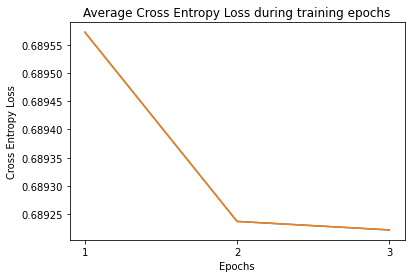

In [11]:
# plotting cross entropy loss
y1 = averages_training
x1 = epoch_list
plt.plot(x1, y1, label = "Training")

plt.plot(epoch_list, averages_training)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.xticks(np.arange(min(x1), max(x1)+1, 1))
plt.title('Average Cross Entropy Loss during training epochs')
plt.savefig('test:newQ4: Cross Entropy Loss during training epochs')
plt.show()